In [ ]:
!git clone https://github.com/anonymous174174/404brain-not-found.git

Cloning into '404brain-not-found'...
remote: Enumerating objects: 590, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 590 (delta 45), reused 45 (delta 34), pack-reused 522 (from 1)
Receiving objects: 100% (590/590), 1.06 MiB | 16.14 MiB/s, done.
Resolving deltas: 100% (376/376), done.


In [ ]:
%cd /content/404brain-not-found

/content/404brain-not-found


In [ ]:
!pip install -e .


Obtaining file:///content/404brain-not-found
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 46.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
%cd ..

/content


In [ ]:
# @title Modules
import sys
sys.path.append('/content/404brain-not-found/src')
import importlib
import neuronix
import neuronix.autograd_graph
import neuronix.custom_tensor
import neuronix.module
import neuronix.losses
import neuronix.optimizers
import neuronix.config
from neuronix.autograd_graph import AutogradGraph
from neuronix.custom_tensor import CustomTensor
from neuronix.module import *
from neuronix.losses import *
from neuronix.optimizers import *
from neuronix.config import *

importlib.reload(neuronix)
importlib.reload(neuronix.autograd_graph)
importlib.reload(neuronix.custom_tensor)
importlib.reload(neuronix.module)
importlib.reload(neuronix.losses)
importlib.reload(neuronix.optimizers)
importlib.reload(neuronix.config)

<module 'neuronix.config' from '/content/404brain-not-found/src/neuronix/config.py'>

In [ ]:
# @title FastNet t0 architecture
import neuronix.module as m
import neuronix.losses as l

class MLPBlock(m.Module):
    def __init__(self,
                 in_channels,
                 n_div,
                 mlp_ratio,graph):
      super().__init__()
      self.spatial_mixing= m.Partial_Conv_2d(
          in_channels=in_channels,
          n_div = n_div,
          kernel_size = 3,
          dilation=1,
          graph=graph
      )
      mlp_layer = [
          m.Conv2d(
              in_channels=in_channels,
              out_channels=int(in_channels*mlp_ratio),
              kernel_size=1,
              bias=False,
              graph=graph
          ),
          m.BatchNorm_Nd(
              num_features=int(in_channels*mlp_ratio),
              graph=graph
          ),
          m.ReLu(graph=graph),
          m.Conv2d(
              in_channels=int(in_channels*mlp_ratio),
              out_channels=in_channels,
              kernel_size=1,
              bias=False,
              graph=graph
          ),
      ]
      self.mlp = m.Sequential(*mlp_layer)

    def forward(self,x):
      x_skip = x
      x = self.spatial_mixing(x)
      x = x_skip + self.mlp(x)
      return x

class BasicStage(m.Module):
    def __init__(self,
                 in_channels,
                 n_div,
                 mlp_ratio,
                 num_blocks,
                 graph):
      super().__init__()
      blocks_l = [
          MLPBlock(
              in_channels=in_channels,
              n_div=n_div,
              mlp_ratio=mlp_ratio,
              graph=graph
          )
          for _ in range(num_blocks)
      ]
      self.blocks = m.Sequential(*blocks_l)

    def forward(self,x):
      x = self.blocks(x)
      return x

class PatchMerging(m.Module):
    def __init__(self,
                 in_channels,
                 kernel_size,
                 stride,
                 graph):
      super().__init__()
      self.reduction = m.Conv2d(
          in_channels=in_channels,
          out_channels=2*in_channels,
          kernel_size=kernel_size,
          stride=stride,
          bias=False,
          graph=graph)

      self.bn = m.BatchNorm_Nd(
          num_features=2*in_channels,
          graph=graph
      )

    def forward(self,x):
      x = self.reduction(x)
      x = self.bn(x)
      return x

# this is used for Image classification the architecture is different for feature extraction
class FastNet(m.Module):
    def __init__(self,
                 in_channels=3,
                 num_classes=10,
                 embed_dim=96,
                 depths = (1,2,4,8),
                 mlp_ratio = 2.,
                 n_div =4,
                 patch_size_input=4,
                 patch_stride_input=4,
                 patch_size_merge=2,
                 patch_stride_merge=2,
                 feature_dim=1280,
                 input_size=224,
                 graph=None
                 ):
      super().__init__()
      num_stages = len(depths)
      num_features = int(embed_dim * 2 ** (num_stages - 1))

      embed_input = [
          m.Conv2d(
              in_channels=in_channels,
              out_channels=embed_dim,
              kernel_size=patch_size_input,
              stride=patch_stride_input,
              bias=False,
              graph=graph
          ),
          m.BatchNorm_Nd(
              num_features=embed_dim,
              graph=graph
          )
      ]


      self.patch_embed = m.Sequential(*embed_input)
      stages_list=[]
      for stage_number in range(num_stages):
         stage = BasicStage(
             in_channels=int(embed_dim * 2 ** stage_number),
             n_div=n_div,
             mlp_ratio=mlp_ratio,
             num_blocks=depths[stage_number],
             graph=graph
         )
         stages_list.append(stage)
         if stage_number < num_stages - 1:
            stages_list.append(PatchMerging(
                in_channels=int(embed_dim * 2 ** stage_number),
                kernel_size=patch_size_merge,
                stride=patch_stride_merge,
                graph=graph
            ))

      self.stages = m.Sequential(*stages_list)
      self.avg_pool_pre_head = m.Sequential(
          m.AvgPool2d(
          kernel_size=FastNet.compute_final_resolution(input_size,input_size,patch_size_input,patch_stride_input,patch_size_merge,patch_stride_merge,num_stages),
          stride=1,
          padding=0,
          graph=graph
        ),
          m.Conv2d(
          in_channels=num_features,
          out_channels=feature_dim,
          kernel_size=1,
          bias=False,
          graph=graph
        ),
          m.ReLu(graph=graph)
      )
      # flatten in forward before passing the output
      self.head = m.Linear(
          in_features=feature_dim,
          out_features=num_classes,
          graph=graph
      )



    @staticmethod
    def compute_final_resolution(H0, W0,
                              patch_size_input, patch_stride_input,
                              patch_size_merge, patch_stride_merge,
                              num_stages):
      num_merges = num_stages-1

      def conv_downsample(H, K, S):
          return (H - K) // S + 1

      H = conv_downsample(H0, patch_size_input, patch_stride_input)
      W = conv_downsample(W0, patch_size_input, patch_stride_input)

      for _ in range(num_merges):
          H = conv_downsample(H, patch_size_merge, patch_stride_merge)
          W = conv_downsample(W, patch_size_merge, patch_stride_merge)

      return H, W
    def forward(self,x):
      x=self.patch_embed(x)
      x=self.stages(x)
      x=self.avg_pool_pre_head(x)
      x=x.reshape((x.shape[0],-1))
      x=self.head(x)
      return x

In [ ]:
# @title Sanity Check
model=FastNet(graph=None)
model.eval()
sample_input = CustomTensor(torch.randn(1,3,224,224), _custom_requires_grad=False, graph=None)
output=model(sample_input)
print(output)
del model,sample_input,output
with AutogradGraph() as graph:
    model=FastNet(graph=None)
    model.train()
    model.attach_graph(graph)
    lf = l.CrossEntropyLoss(graph=graph)
    sample_input = CustomTensor(torch.randn(5,3,224,224), _custom_requires_grad=False, graph=None)
    output = model(sample_input)
    target_class_tensor = CustomTensor([0.,3.,2.,5.,4.],dtype=torch.long,_custom_requires_grad=False, graph=None)
    loss = lf(output, target_class_tensor)
    loss.backward()
del graph,model,lf,sample_input,output,target_class_tensor,loss

CustomTensor(
  memory_address   = 0x7afa01ab3470,
  shape            = torch.Size([1, 10]),
  requires_grad    = False,
  node_id          = None,
  is_leaf          = False
)


### testing on cifar10

In [ ]:
# @title Training Loop for FastNet T0 on cifar10
import os
import sys
import csv
import torch
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms.v2 as T
import torchvision.transforms as transforms
from neuronix.optimizers import AdamW
from neuronix.autograd_graph import AutogradGraph
from neuronix.custom_tensor import CustomTensor
from neuronix.lr_scheduler import CosineAnnealingLR
import neuronix.losses as l
import glob
from neuronix.config import device,dtype
# Configuration
SAVE_PATH = os.path.join(os.getcwd(),"experiments")  # Base directory for saving experiments
EXP_NAME = "FastNet_t0_cifar10"  # Experiment name
CHECKPOINT_INTERVAL = 10  # Save checkpoint every N epochs
N_EPOCHS = 15
BATCH_SIZE = 128
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.01
MAX_SAVED_MODELS = 3  # Maximum number of models to keep

# Verify and create directories
if not os.path.exists(SAVE_PATH):
    print(f"Creating save path: {SAVE_PATH}")
    os.makedirs(SAVE_PATH)

if not os.path.isdir(SAVE_PATH):
    print(f"Error: Save path is not a directory: {SAVE_PATH}")
    sys.exit(1)

# Create directories for saving models and logs
os.makedirs(os.path.join(SAVE_PATH, EXP_NAME, "saves"), exist_ok=True)
os.makedirs(os.path.join(SAVE_PATH, EXP_NAME, "logs"), exist_ok=True)
SAVE_PATH_MODEL_BEST = os.path.join(SAVE_PATH, EXP_NAME, "saves","best")
SAVE_PATH_MODEL_CHECKPOINT = os.path.join(SAVE_PATH, EXP_NAME, "saves","checkpoint")
os.makedirs(SAVE_PATH_MODEL_BEST,exist_ok=True)
os.makedirs(SAVE_PATH_MODEL_CHECKPOINT,exist_ok=True)
LOG_FILE_PATH = os.path.join(SAVE_PATH, EXP_NAME, "logs")

# Create log files
train_log_file_path = os.path.join(LOG_FILE_PATH, f"{EXP_NAME}_train_log.csv")
test_log_file_path = os.path.join(LOG_FILE_PATH, f"{EXP_NAME}_test_log.csv")

train_log_file = open(train_log_file_path, mode="a", newline="")
test_log_file = open(test_log_file_path, mode="a", newline="")

train_writer = csv.writer(train_log_file)
test_writer = csv.writer(test_log_file)

# Write headers only if the file is empty
if os.stat(train_log_file_path).st_size == 0:
    train_writer.writerow(["epoch", "batch", "lr", "loss", "accuracy"])

if os.stat(test_log_file_path).st_size == 0:
    test_writer.writerow(["epoch", "loss", "accuracy"])

# # Load the dataset
# train_dataset = ImageFolder(root='/content/inaturalist_12K/train', transform=train_transform)
# test_dataset = ImageFolder(root='/content/inaturalist_12K/val', transform=val_transform)

# # Create DataLoaders
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True,prefetch_factor=16)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True,prefetch_factor=16)

# Define transformations
# train_transform = T.Compose([
#     T.RandomCrop(32, padding=4),
#     T.RandomHorizontalFlip(),
#     T.RandomRotation(10),
#     T.ColorJitter(0.1, 0.1, 0.1, 0.05),
#     T.ToDtype(torch.float32, scale=True),
#     T.Normalize(mean=[0.4914, 0.4822, 0.4465],
#                 std=[0.2023, 0.1994, 0.2010])
# ])

# val_transform = T.Compose([
#     T.ToDtype(torch.float32, scale=True),
#     T.Normalize(mean=[0.4914, 0.4822, 0.4465],
#                 std=[0.2023, 0.1994, 0.2010])
# ])

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],std=[0.2023, 0.1994, 0.2010])
])


# Download and load training data
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                              download=True, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2,pin_memory=True,prefetch_factor=16)

# Download and load test data
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                             download=True, transform=val_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2,pin_memory=True,prefetch_factor=16)
# Initialize model and optimizer
model = FastNet(in_channels=3,
                num_classes=10,
                embed_dim=96,
                depths=(1,2,4),
                mlp_ratio=2.,
                n_div=4,
                patch_size_input=4,
                patch_stride_input=1,
                patch_size_merge=2,
                patch_stride_merge=2,
                feature_dim=384,
                input_size=32,
                graph=None)

optimizer = AdamW(params=model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingLR(optimizer, T_max=N_EPOCHS, eta_min=1e-5)

print(f'Optimizer: AdamW')
print(f'Learning Rate: {LEARNING_RATE}')
print(f'Weight Decay: {WEIGHT_DECAY}')
print(f'Max Epochs: {N_EPOCHS}')
print(f'Batch Size: {BATCH_SIZE}')

print(f'Scheduler: Cosine Annealing')
print(f'T_max: {N_EPOCHS}')
print(f'eta_min: {1e-5}')

# Training variables
best_test_accuracy = 0.0
best_test_loss = float('inf')

def calculate_accuracy(outputs, labels):
    """Calculate accuracy for classification"""
    predicted = torch.argmax(outputs.tensor, dim=1)
    correct = (predicted == labels.tensor).float().sum()
    accuracy = correct / labels.tensor.size(0)
    return accuracy.item()

def cleanup_old_models(model_dir, max_models=5):
    """Keep only the most recent models, delete older ones"""
    # Get all model files (both best and checkpoint)
    model_files = glob.glob(os.path.join(model_dir, "*.pth"))

    if len(model_files) <= max_models:
        return

    # Sort files by modification time (newest first)
    model_files.sort(key=os.path.getmtime, reverse=True)

    # Keep only the newest max_models files
    files_to_keep = model_files[:max_models]
    files_to_delete = model_files[max_models:]

    # Delete old files
    for file_path in files_to_delete:
        try:
            os.remove(file_path)
            print(f"Deleted old model: {os.path.basename(file_path)}")
        except OSError as e:
            print(f"Error deleting {file_path}: {e}")

def save_model_with_cleanup(model, optimizer, scheduler, epoch, loss, accuracy, save_path, model_dir, is_best=False):
    """Save model and maintain maximum number of saved models"""
    model_state = {
        'epoch': epoch,
        'model_state_dict':  model,
        'optimizer_state_dict': optimizer,
        'scheduler_state_dict': scheduler,
        'test_loss': loss,
        'test_accuracy': accuracy,
    }

    # Save the model
    if hasattr(torch, 'save'):
        torch.save(model_state, save_path)
    else:
        # If torch.save is not available, implement custom save
        print(f"Custom save logic needed for: {save_path}")

    # Clean up old models to maintain maximum count
    cleanup_old_models(model_dir, MAX_SAVED_MODELS)

    if is_best:
        print(f"Best model saved at epoch {epoch} with test accuracy {accuracy:.4f}")
    else:
        print(f"Checkpoint saved at epoch {epoch}")

# Training loop with AutogradGraph
with AutogradGraph() as graph:
    model.attach_graph(graph)
    lf = l.CrossEntropyLoss(graph=graph)

    for epoch in range(N_EPOCHS):
        # Training phase
        model.train()
        lf.train()
        print(f"\n-----------------------------Training Epoch : {epoch}-----------------------------------")
        epoch_train_loss = 0.0
        epoch_train_accuracy = 0.0
        # with torch.inference_mode():
        for i, (images, labels) in enumerate(train_loader):
            #labels = labels.to(device=device,dtype=torch.long,non_blocking=True)
            images = CustomTensor(images, _custom_requires_grad=False, graph=None, device = device,dtype=dtype)
            labels = CustomTensor(labels, _custom_requires_grad=False, graph=None, device = device, dtype= torch.long)

            optimizer.zero_grad()
            output = model(images)
            loss = lf(output, labels)
            loss.backward()
            optimizer.step()

            loss_value = loss.tensor.item()
            accuracy = calculate_accuracy(output, labels)

            epoch_train_loss += loss_value
            epoch_train_accuracy += accuracy
            current_lr = optimizer.param_groups[0]['lr']
            # Log training batch
            train_writer.writerow([
                epoch, i, current_lr , loss_value, accuracy
            ])

            sys.stdout.write(
                "\r Training : [Epoch %d/%d] [Batch %d/%d] [lr: %.6f, loss: %.6f, accuracy: %.4f]"
                % (
                    epoch + 1, N_EPOCHS, i + 1, len(train_loader),
                    current_lr, loss_value, accuracy
                )
            )
            sys.stdout.flush()
        scheduler.step()
        epoch_train_loss /= len(train_loader)
        epoch_train_accuracy /= len(train_loader)

        # Testing/Validation phase
        model.eval()
        lf.eval()
        print(f"\n---------------------------Testing Epoch : {epoch}---------------------------------")
        epoch_test_loss = 0.0
        epoch_test_accuracy = 0.0
        with torch.inference_mode():
            for j, (images, labels) in enumerate(test_loader):
                images = CustomTensor(images, _custom_requires_grad=False, graph=None,device = device ,dtype = dtype)
                labels = CustomTensor(labels, _custom_requires_grad=False, graph=None, device = device,dtype=torch.long)

                output = model(images)

                loss = lf(output, labels)

                loss_value = loss.tensor.item()
                accuracy = calculate_accuracy(output, labels)

                epoch_test_loss += loss_value
                epoch_test_accuracy += accuracy

                sys.stdout.write(
                    "\r Testing : [Epoch %d/%d] [Batch %d/%d] [loss: %.6f, accuracy: %.4f]"
                    % (
                        epoch + 1, N_EPOCHS, j + 1, len(test_loader),
                        loss_value, accuracy
                    )
                )
                sys.stdout.flush()

        epoch_test_loss /= len(test_loader)
        epoch_test_accuracy /= len(test_loader)

        # Log test results
        test_writer.writerow([epoch, epoch_test_loss, epoch_test_accuracy])

        print(f"\nTest Loss: {epoch_test_loss:.6f}, Test Accuracy: {epoch_test_accuracy:.4f}")

        # Save best model based on accuracy
        if epoch_test_accuracy > best_test_accuracy:
            best_test_accuracy = epoch_test_accuracy
            best_test_loss = epoch_test_loss
            save_path = os.path.join(SAVE_PATH_MODEL_BEST, f"model_best_epoch_{epoch + 1}_acc_{best_test_accuracy:.4f}.pth")
            model.prepare_for_saving()
            save_model_with_cleanup(
                model, optimizer, scheduler,epoch + 1,
                best_test_loss, best_test_accuracy,
                save_path, SAVE_PATH_MODEL_BEST, is_best=True
            )
            model.attach_graph(graph=graph)

        # Save checkpoint at regular intervals
        elif (epoch + 1) % CHECKPOINT_INTERVAL == 0:
            save_path = os.path.join(SAVE_PATH_MODEL_CHECKPOINT, f"model_checkpoint_epoch_{epoch + 1}.pth")
            model.prepare_for_saving()
            save_model_with_cleanup(
                model, optimizer, scheduler,epoch + 1,
                epoch_test_loss, epoch_test_accuracy,
                save_path, SAVE_PATH_MODEL_CHECKPOINT, is_best=False
            )
            model.attach_graph(graph=graph)

# Close log files
train_log_file.close()
test_log_file.close()


print(f"\nTraining completed!")
print(f"Best test accuracy: {best_test_accuracy:.4f}")
print(f"Best test loss: {best_test_loss:.6f}")
print(f"Logs saved in: {LOG_FILE_PATH}")
print(f"Models saved in: {SAVE_PATH_MODEL_BEST}")


Optimizer: AdamW
Learning Rate: 0.001
Weight Decay: 0.01
Max Epochs: 15
Batch Size: 128
Scheduler: Cosine Annealing
T_max: 15
eta_min: 1e-05

-----------------------------Training Epoch : 0-----------------------------------
 Training : [Epoch 1/15] [Batch 391/391] [lr: 0.001000, loss: 1.225376, accuracy: 0.5375]
---------------------------Testing Epoch : 0---------------------------------
 Testing : [Epoch 1/15] [Batch 79/79] [loss: 1.547259, accuracy: 0.5000]
Test Loss: 1.347306, Test Accuracy: 0.5329
Best model saved at epoch 1 with test accuracy 0.5329

-----------------------------Training Epoch : 1-----------------------------------
 Training : [Epoch 2/15] [Batch 391/391] [lr: 0.000989, loss: 1.134271, accuracy: 0.6375]
---------------------------Testing Epoch : 1---------------------------------
 Testing : [Epoch 2/15] [Batch 79/79] [loss: 1.092439, accuracy: 0.6250]
Test Loss: 1.174095, Test Accuracy: 0.5862
Best model saved at epoch 2 with test accuracy 0.5862

--------------

In [ ]:
import os

def get_file_sizes(directory, extensions=(".pth",)):
    print(f"Checking file sizes in: {directory}\n")

    total_size = 0
    file_info = []

    for filename in os.listdir(directory):
        if filename.endswith(extensions):
            path = os.path.join(directory, filename)
            size_bytes = os.path.getsize(path)
            size_mb = size_bytes / (1024 * 1024)
            file_info.append((filename, size_mb))
            total_size += size_mb

    if not file_info:
        print("No matching files found.")
        return

    for fname, size in sorted(file_info, key=lambda x: -x[1]):
        print(f"{fname:50} : {size:.2f} MB")

    print(f"\nTotal size: {total_size:.2f} MB")

# Example usage
SAVE_PATH_MODEL = "/content/experiments/FastNet_t0_cifar10/saves/best"
get_file_sizes(SAVE_PATH_MODEL)


Checking file sizes in: /content/experiments/FastNet_t0_cifar10/saves/best

model_best_epoch_15_acc_0.8804.pth                 : 41.35 MB
model_best_epoch_14_acc_0.8759.pth                 : 41.35 MB
model_best_epoch_13_acc_0.8698.pth                 : 41.35 MB

Total size: 124.04 MB


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
class CSVLossPlotter:
    def __init__(self, file_path):
        """
        Initialize the CSVLossPlotter with the file path to the CSV file.
        """
        self.file_path = file_path
        self.data = None

    def load_csv(self):
        """
        Load the CSV file into a pandas DataFrame.
        """
        try:
            self.data = pd.read_csv(self.file_path)
            print("CSV file loaded successfully!")
        except Exception as e:
            print(f"Error loading CSV file: {e}")

    def plot_losses(self):
        """
        Plot each loss column with a generic index on the x-axis, in separate graphs.
        """
        if self.data is None:
            print("Data not loaded. Please call load_csv() first.")
            return

        # Ensure the required loss columns are present
        loss_columns = ['loss']
        for column in loss_columns:
            if column not in self.data.columns:
                print(f"Column '{column}' not found in the CSV file.")
                return

        # Plot each loss separately
        for column in loss_columns:
            plt.figure(figsize=(10, 6))
            plt.plot(self.data.index, self.data[column], label=column, color='blue')
            plt.title(f"{column.replace('_', ' ').title()} Curve")
            plt.xlabel("Epoch/Iteration (Generic Index)")
            plt.ylabel("Loss Value")
            plt.legend()
            plt.grid(True)
            plt.show()

CSV file loaded successfully!


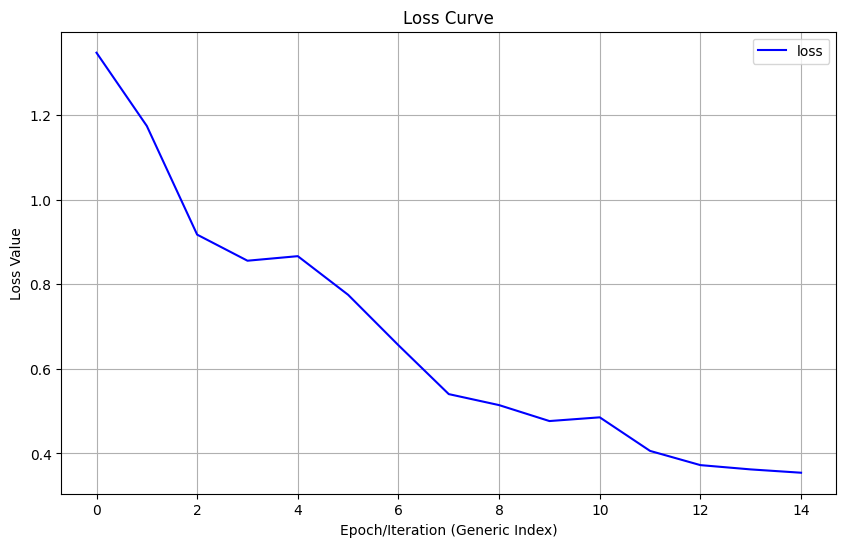

In [ ]:
tlcsv = CSVLossPlotter("/content/experiments/FastNet_t0_cifar10/logs/FastNet_t0_cifar10_test_log.csv")
tlcsv.load_csv()
tlcsv.plot_losses()

CSV file loaded successfully!


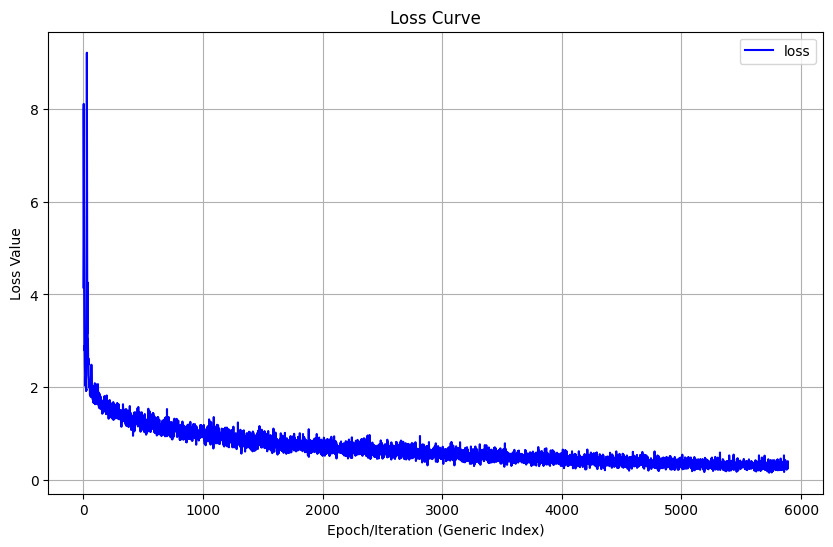

In [ ]:
tlcsv = CSVLossPlotter("/content/experiments/FastNet_t0_cifar10/logs/FastNet_t0_cifar10_train_log.csv")
tlcsv.load_csv()
tlcsv.plot_losses()

In [ ]:
del model, optimizer, scheduler, graph, lf, train_log_file, test_log_file, train_writer, test_writer, train_log_file_path, test_log_file_path, train_dataset, train_loader, test_dataset, test_loader
import gc
torch.cuda.empty_cache()
gc.collect()

8